## Imports

In [36]:
import pandas as pd
# import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import analysis_util
import tqdm
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Data

In [2]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird']
period = '2015-01-01-2022-01-01'

df_post_dict = {}
df_comment_dict = {}
df_all_nodes_dict = {}
G_dict = {}
G_di_dict = {}
df_authors_dict = {}


for subreddit in subreddits:
    path_post='../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_posts.csv"
    path_comment = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_comments.csv"
    
    df_comments=analysis_util.read_comments(path_comment)
    df_post=analysis_util.read_posts(path_post)
    df_all_nodes=analysis_util.get_all_nodes(df_post,df_comments)
    
    G_di = analysis_util.get_DiGraph(df_post,df_comments,df_all_nodes)
    G=analysis_util.get_graph(df_post,df_comments,df_all_nodes)
    G_big=analysis_util.get_biggest_component(G)
    
    df_comment_post = analysis_util.get_comment_post_date(df_comments,df_post)
    df_authors = analysis_util.get_authors(G,df_all_nodes,df_comments,df_post,df_comment_post)

    df_comment_dict[subreddit] = df_comments
    df_post_dict[subreddit] = df_post
    df_all_nodes_dict[subreddit] = df_all_nodes
    G_dict[subreddit] = G_big
    df_authors_dict[subreddit] = df_authors
    G_di_dict[subreddit] = G_di

Removed 0.008264462809917328 of the rows
Removed 0.023008849557522026 of the rows
Removed 0.046391752577319645 of the rows
Removed 0.056192660550458795 of the rows
Removed 0.013580246913580174 of the rows
Removed 0.01412429378531077 of the rows


# Plotting Networks

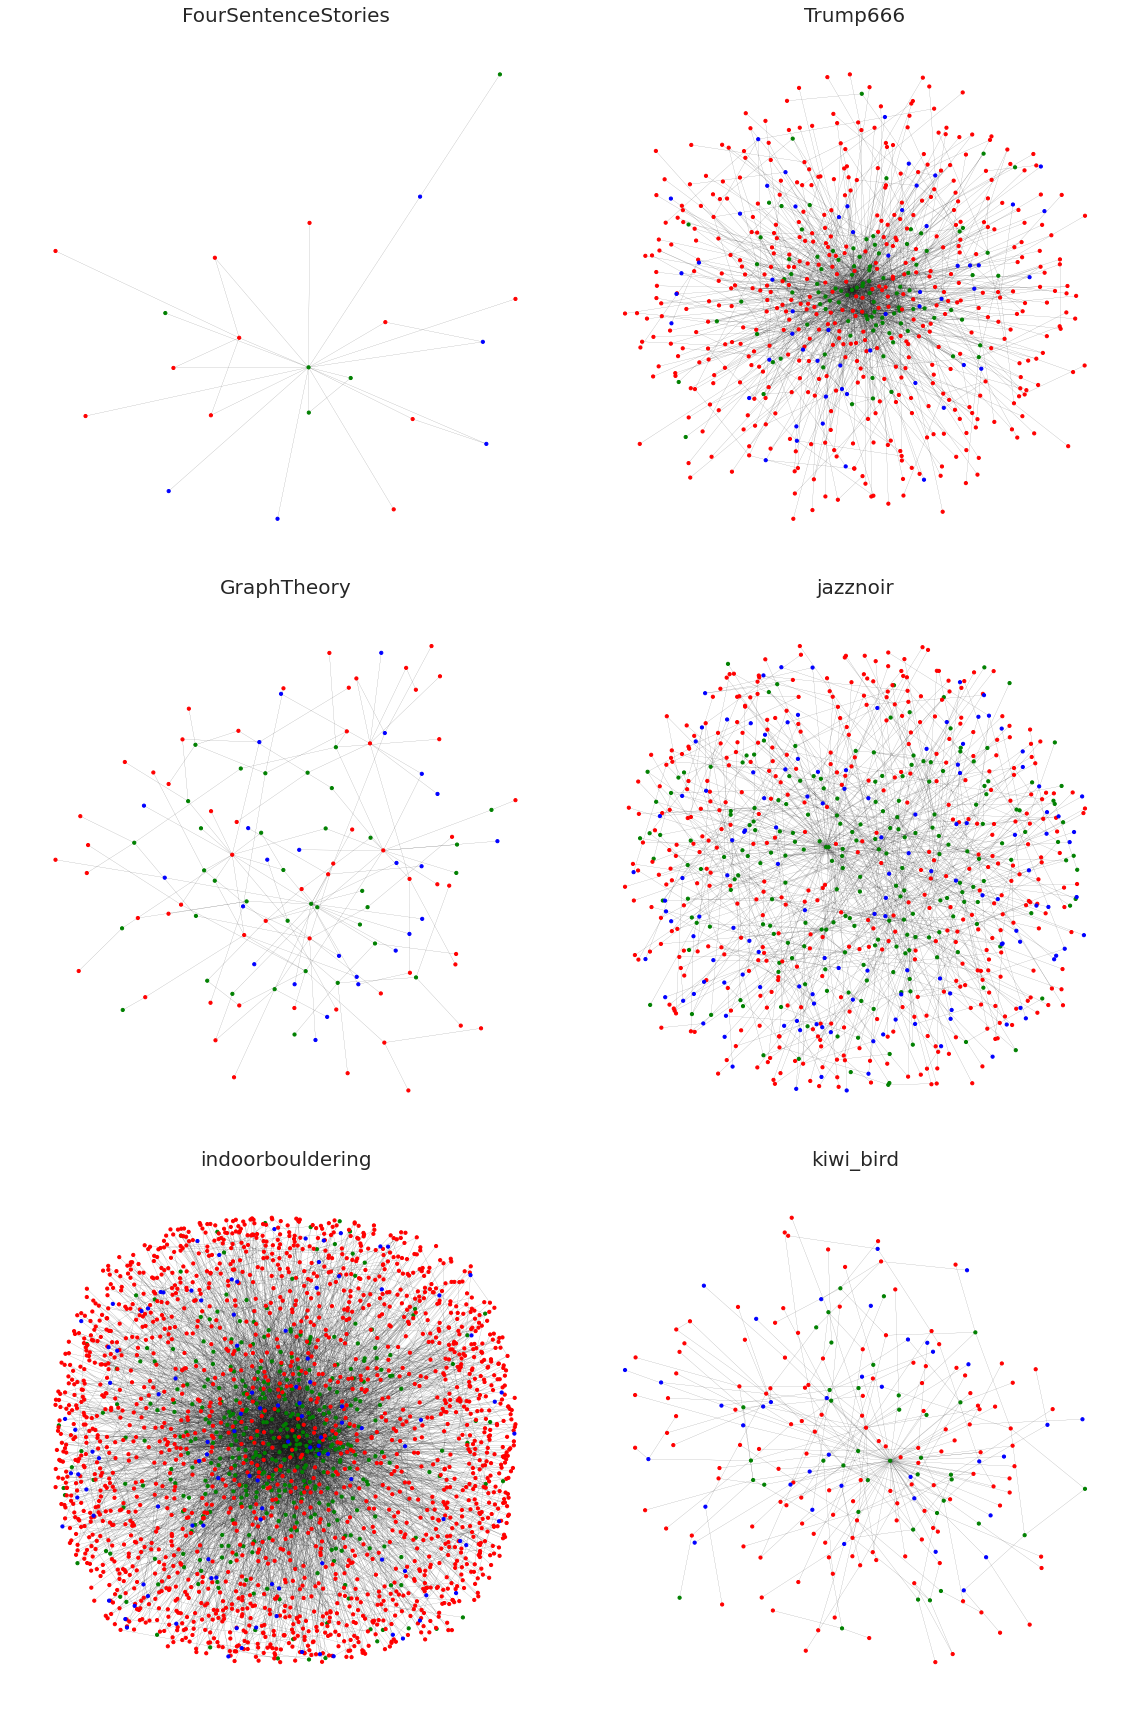

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    color_map = []
    for node in G_dict[subreddit]:
        if type(node) == float: print(node)
        if G_dict[subreddit].nodes[node]['type'] == 'both': color_map.append('green')
        elif G_dict[subreddit].nodes[node]['type'] == 'commenter': color_map.append('red')
        else: color_map.append('blue')

    nx.draw(G_dict[subreddit], 
            node_color=color_map, 
            with_labels=False, 
            ax=axs[i],
            pos=nx.spring_layout(G_dict[subreddit], k=0.15, iterations=20), 
            node_size=10,
            width=.1,
            alpha=1)

    axs[i].set_title(subreddit,fontsize=20)

plt.tight_layout()
plt.show()

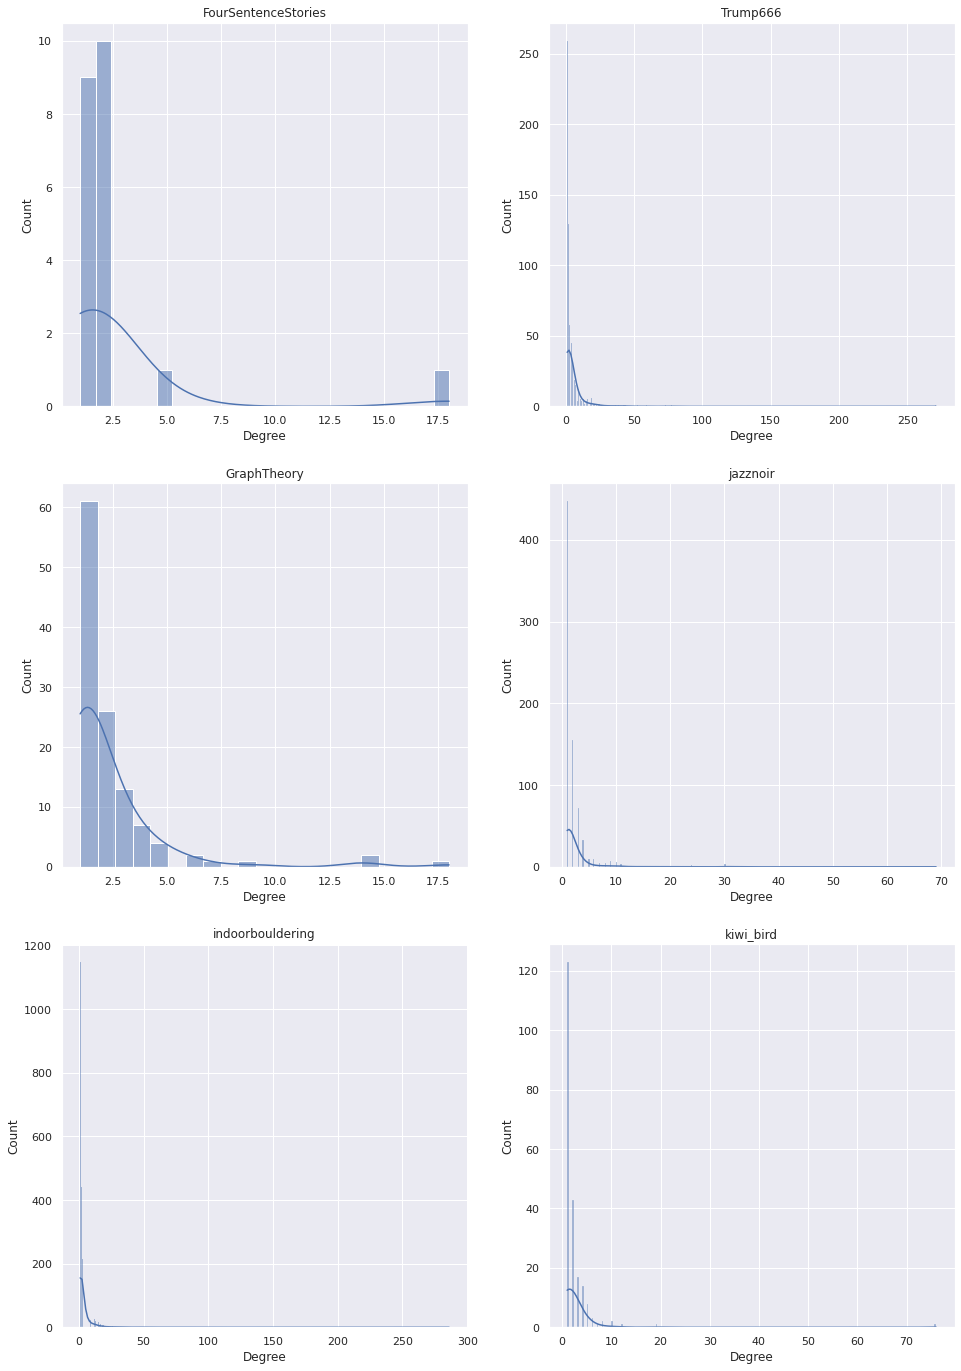

In [4]:
# plot degree distribution
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    degrees = [G_dict[subreddit].degree(n) for n in G_dict[subreddit].nodes]
    sns.histplot(degrees,ax=axs[i],kde=True)
    
    axs[i].set_title(subreddit)
    axs[i].set_xlabel('Degree')
    axs[i].set_ylabel('Count')

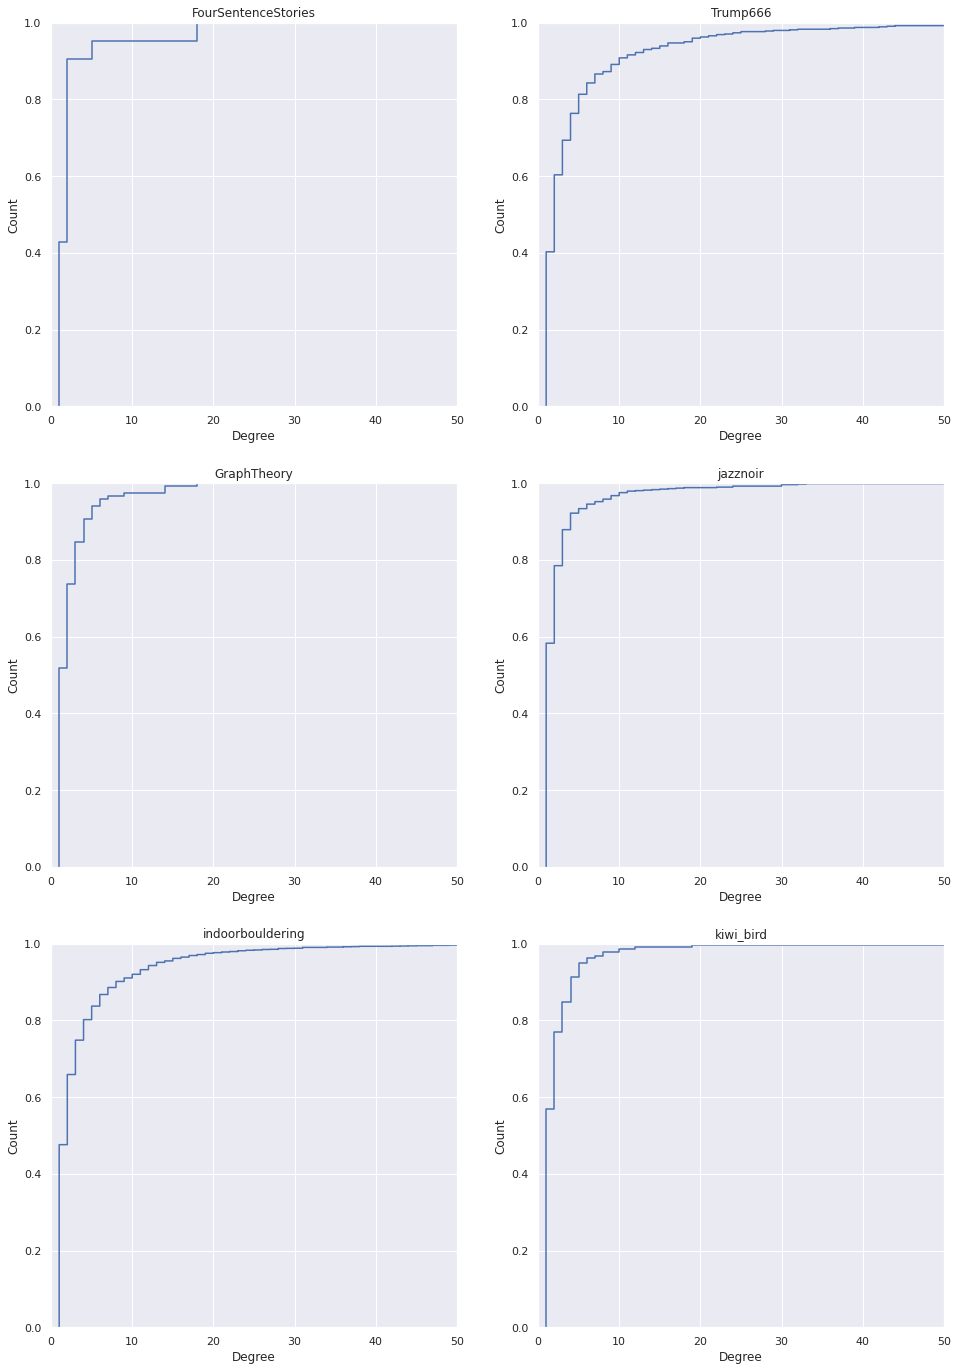

In [28]:
# plot degree accumulative distribution
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    degrees = [G_dict[subreddit].degree(n) for n in G_dict[subreddit].nodes]
    sns.ecdfplot(degrees,ax=axs[i])
    axs[i].set_title(subreddit)
    axs[i].set_xlabel('Degree')
    axs[i].set_ylabel('Count')
    axs[i].set_xlim(0,50)

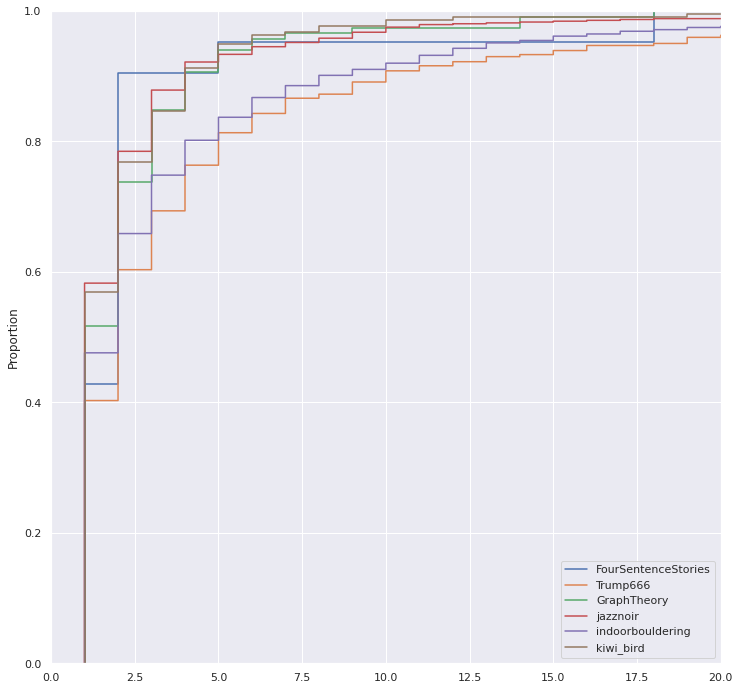

In [27]:
# plot degree accumulative distribution
fig=plt.figure(figsize=(12,12))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    degrees = [G_dict[subreddit].degree(n) for n in G_dict[subreddit].nodes]
    sns.ecdfplot(degrees,log_scale=False,)
    plt.xlim(0,20)
    plt.legend(subreddits)
    # axs[i].set_title(subreddit)
    # axs[i].set_xlabel('Degree')
    # axs[i].set_ylabel('Count')

In [ ]:
# # plot in degree distribution
# fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
# axs = axs.flatten()
# for i,subreddit in enumerate(subreddits):
#     degrees = [G_di_dict[subreddit].out_degree(n) for n in G_di_dict[subreddit].nodes]
#     sns.histplot(degrees,ax=axs[i],kde=True)
#     axs[i].set_title(subreddit)
#     axs[i].set_xlabel('In Degree')
#     axs[i].set_ylabel('Count')

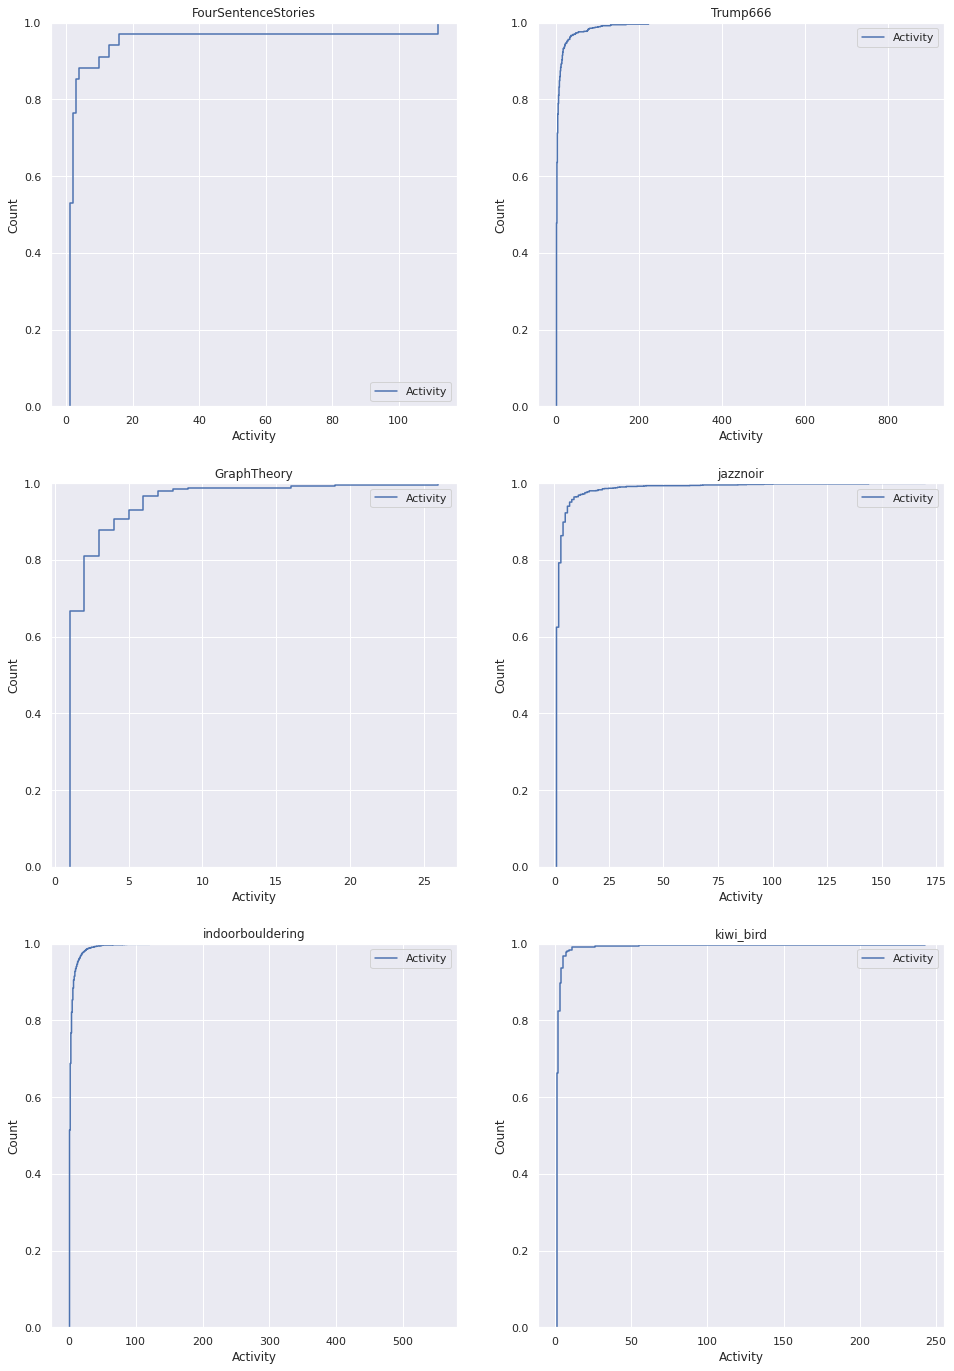

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    sns.ecdfplot([df_authors_dict[subreddit]['Activity']], ax=axs[i])
    axs[i].set_title(subreddit)
    axs[i].set_xlabel('Activity')
    axs[i].set_ylabel('Count')

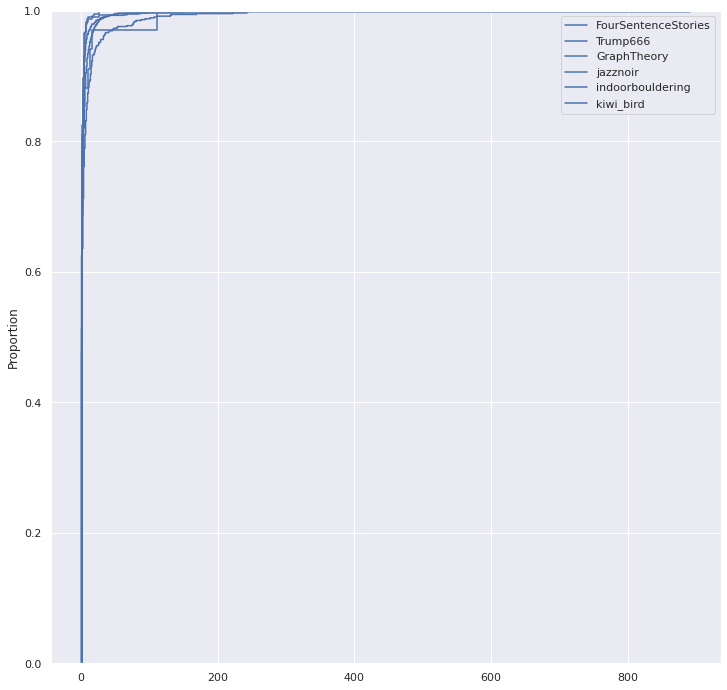

In [31]:
fig = plt.figure(figsize=(12,12))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    sns.ecdfplot([df_authors_dict[subreddit]['Activity']])
    plt.legend(subreddits)

# Correlations

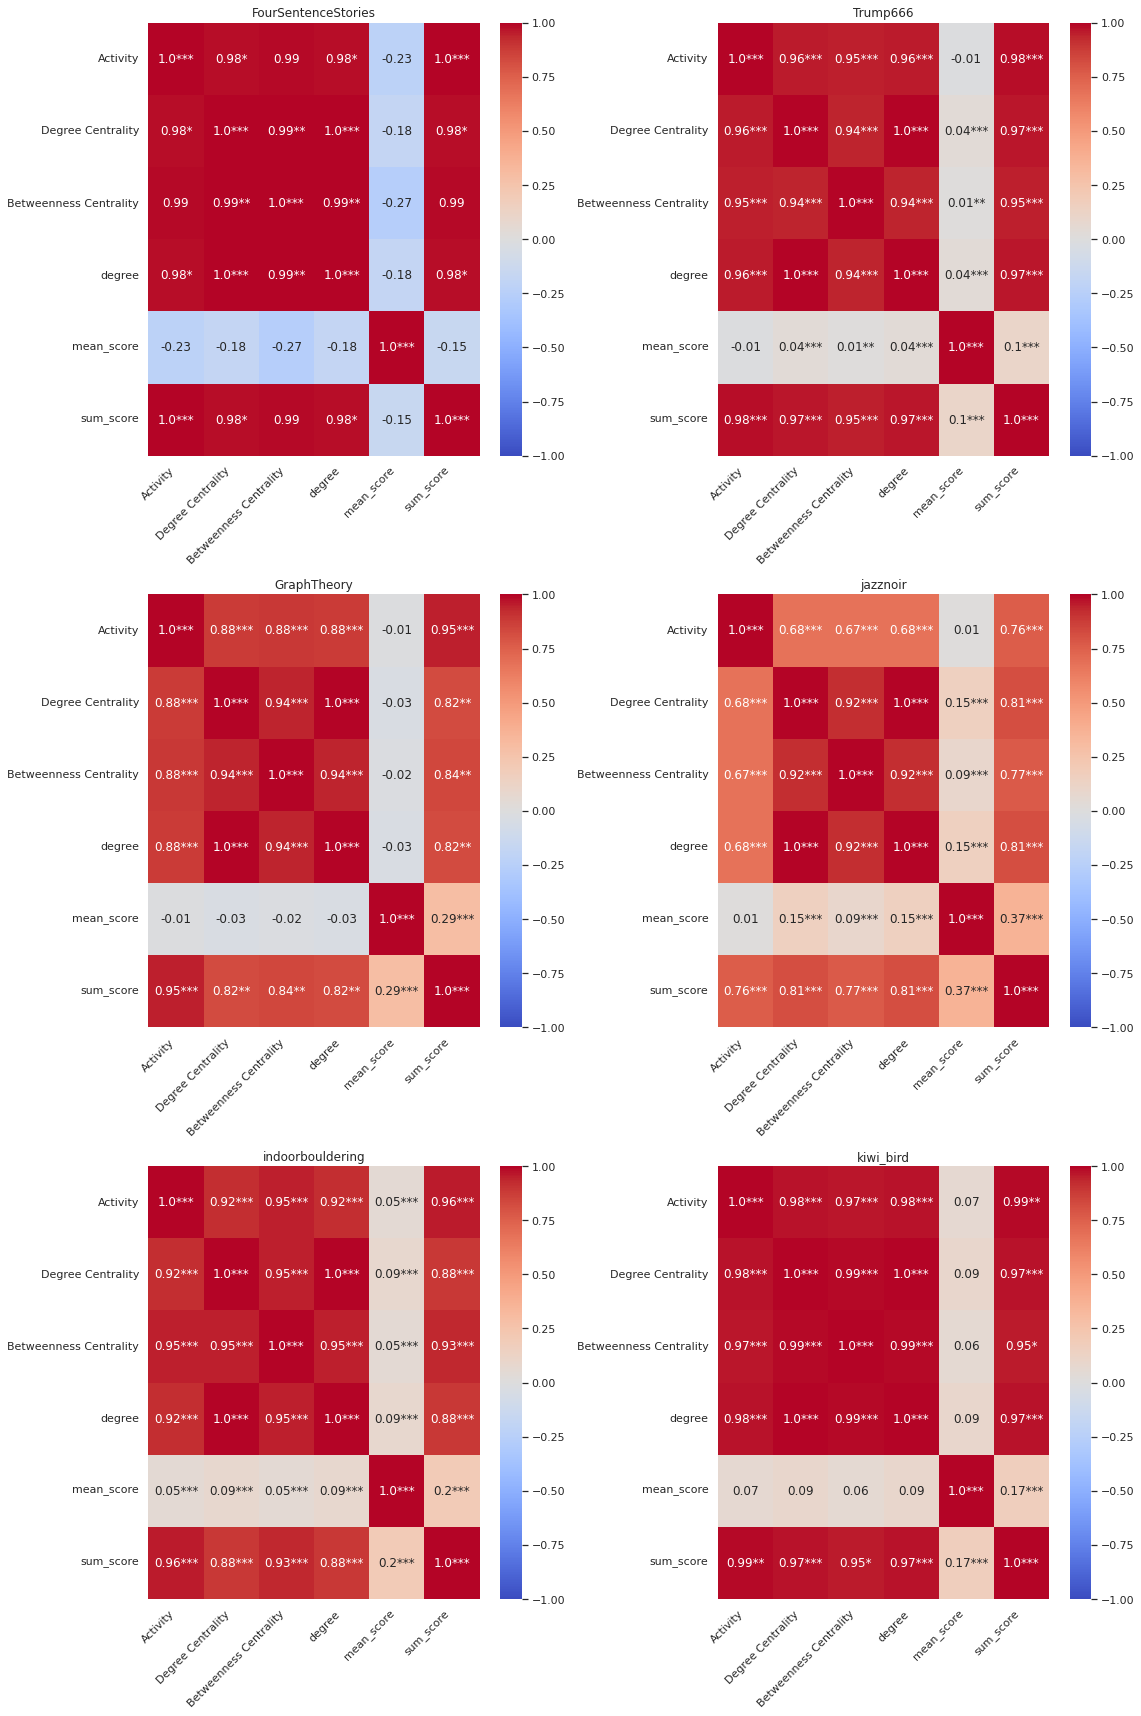

In [42]:
# only for Activity higher than 5
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    rho = df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>3].corr()
    pval = df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>3].corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
    
    # print(pval)

    sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm',ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, horizontalalignment='right')
    axs[i].set_title(subreddit)

plt.tight_layout()
plt.show()

In [10]:
# join df_authors and make corralation matrix
df_authors = pd.concat(df_authors_dict)
df_authors = df_authors.reset_index()
df_authors = df_authors.rename(columns={'level_0':'subreddit','level_1':'author'})

for subreddit in tqdm.tqdm(subreddits):
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_size'] = G_dict[subreddit].number_of_nodes()
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_edges'] = G_dict[subreddit].number_of_edges()
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_average_clustering'] = nx.average_clustering(G_dict[subreddit])
    df_authors.loc[df_authors['subreddit']==subreddit,'graph_average_shortest_path_length'] = nx.average_shortest_path_length(G_dict[subreddit])
    
df_authors.head(5)

100%|██████████| 6/6 [00:59<00:00,  9.93s/it]


,subreddit,author,Activity,Degree Centrality,Betweenness Centrality,degree,type,mean_score,sum_score,graph_size,graph_edges,graph_average_clustering,graph_average_shortest_path_length
0,FourSentenceStories,SkyFallingUp,112,0.545455,0.336174,18,both,1.330357,149,21.0,26.0,0.444725,2.033333
1,FourSentenceStories,LostInThoughtland,16,0.060606,0.000000,2,both,1.937500,31,21.0,26.0,0.444725,2.033333
2,FourSentenceStories,hit_th3_lights,13,0.151515,0.038826,5,commenter,1.923077,25,21.0,26.0,0.444725,2.033333
3,FourSentenceStories,zsirdagadek,10,0.060606,0.000000,2,both,1.600000,16,21.0,26.0,0.444725,2.033333
4,FourSentenceStories,echo-94-charlie,4,0.030303,0.000000,1,both,1.000000,4,21.0,26.0,0.444725,2.033333


- Correlation between mean score of author and the size of the graph
    - more interactions == more upvotes


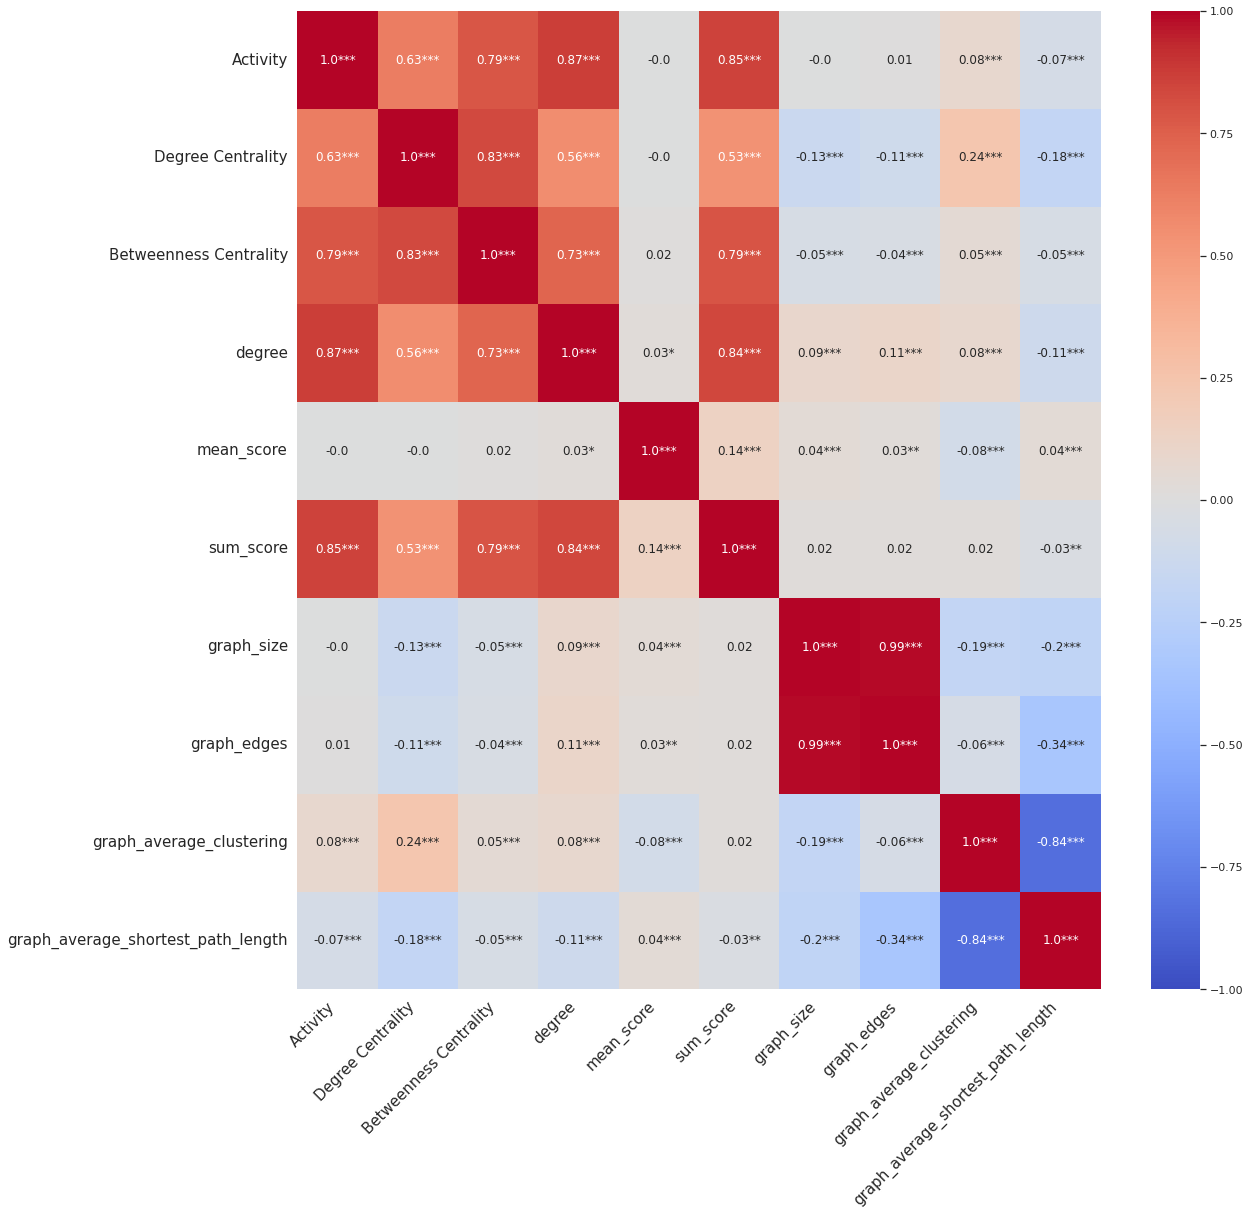

In [29]:
rho = df_authors.corr()
pval = df_authors.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))

fig, ax = plt.subplots(figsize=(18,18))

sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm')

# rotate xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15)
plt.show()

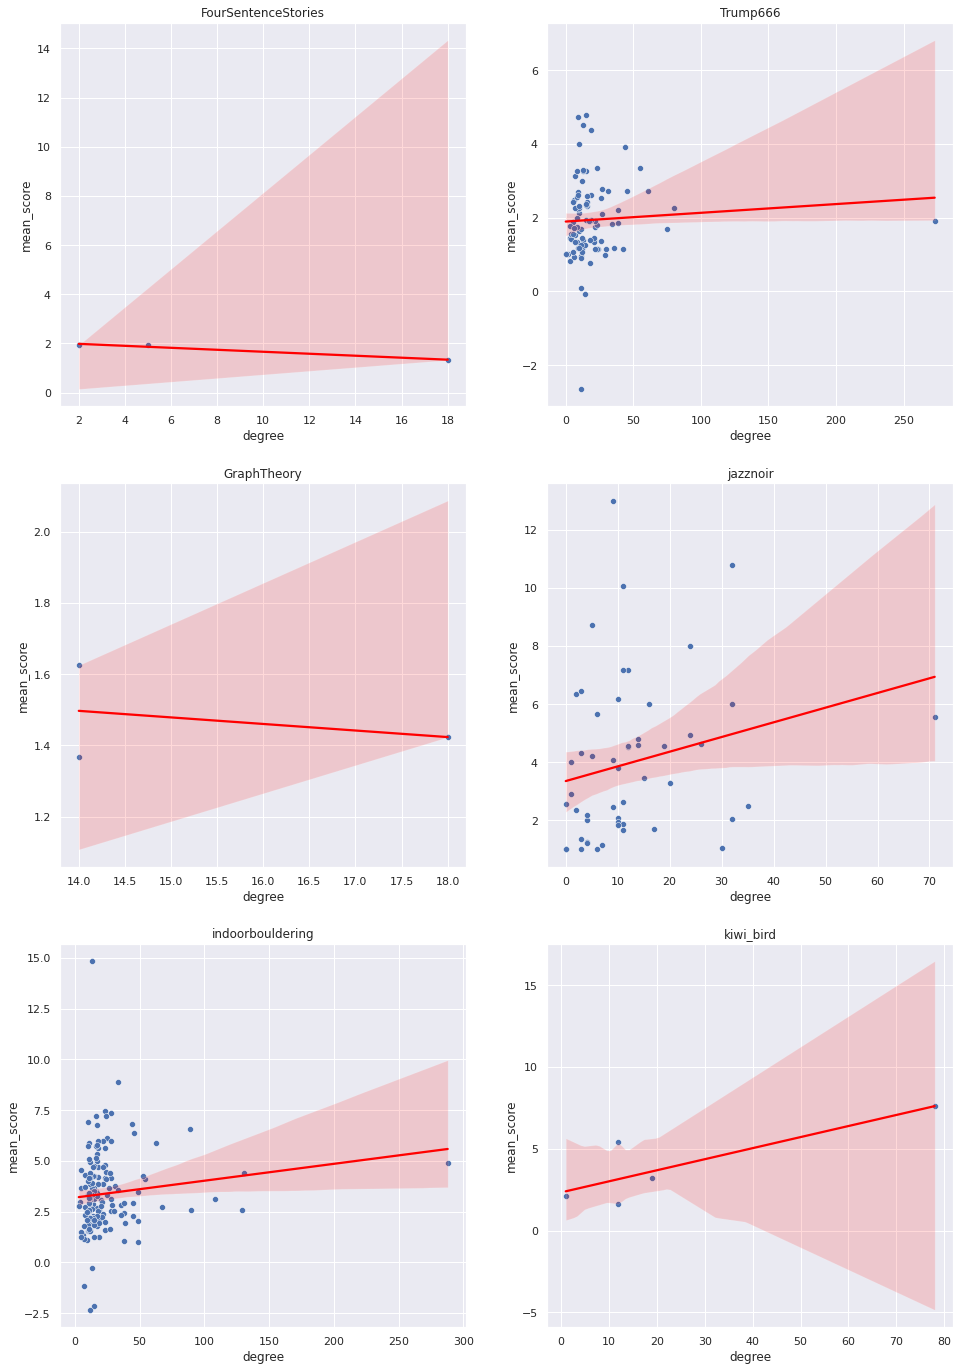

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    sns.scatterplot(x='degree',y='mean_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i])
    # plot correlation line
    sns.regplot(x='degree',y='mean_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i],scatter=False,color='red')
    axs[i].set_title(subreddit)

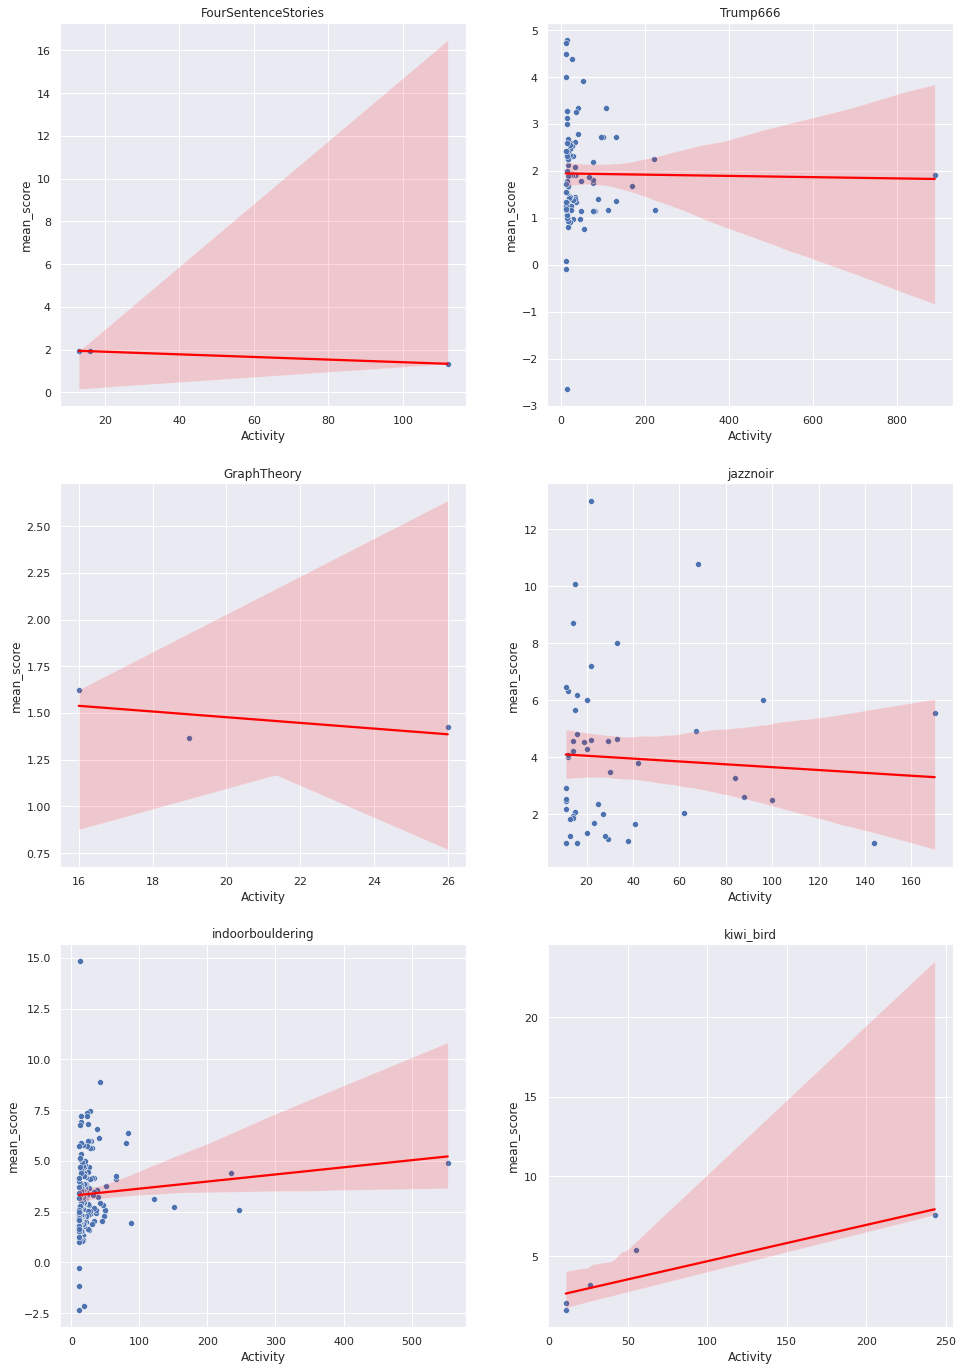

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    sns.scatterplot(x='Activity',y='mean_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i])
    # plot correlation line
    sns.regplot(x='Activity',y='mean_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i],scatter=False,color='red')
    axs[i].set_title(subreddit)

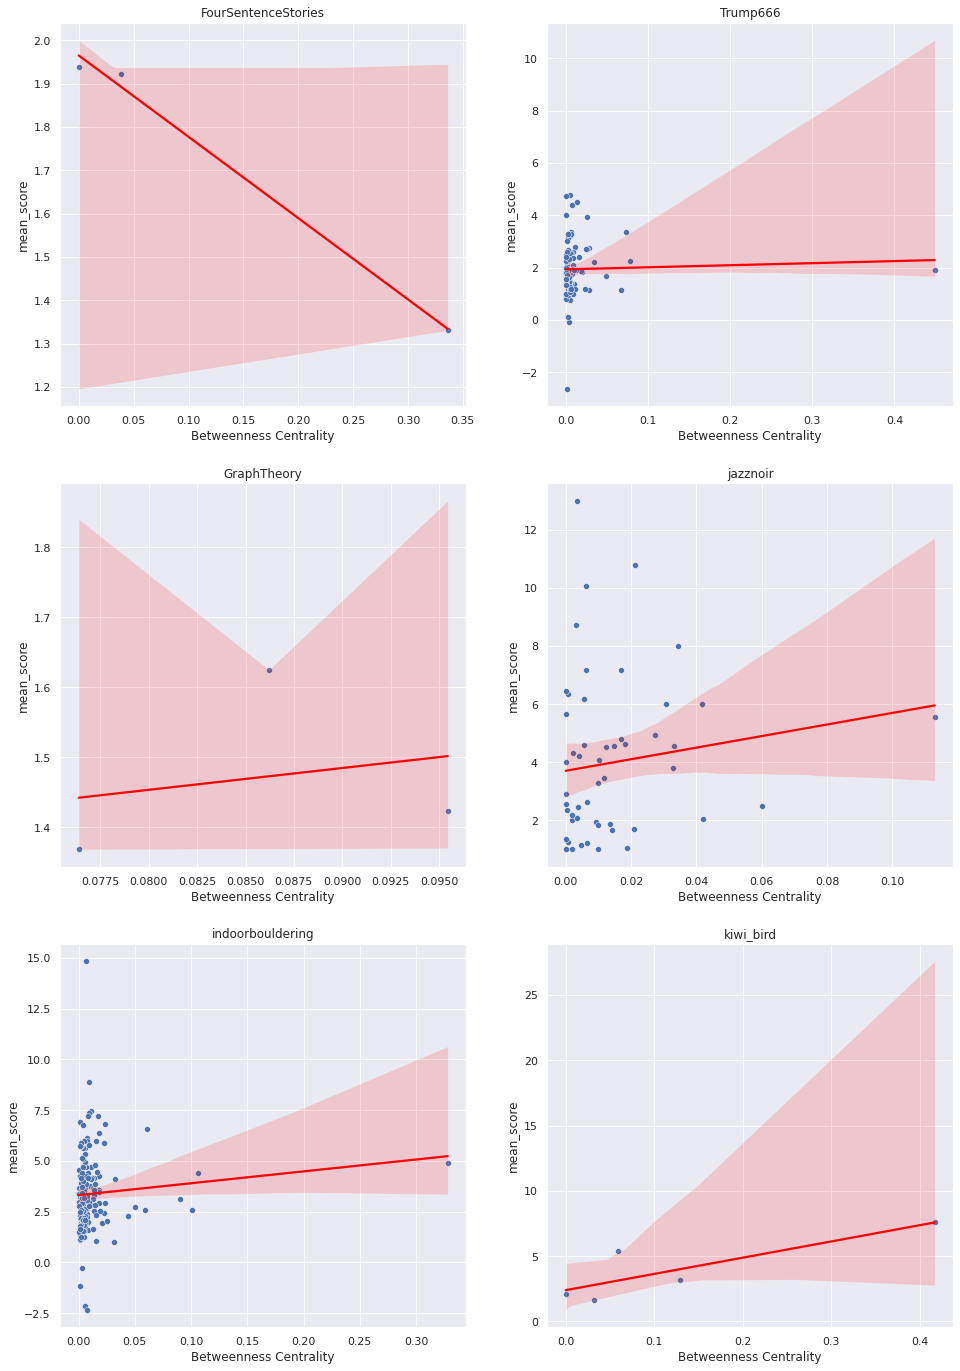

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    sns.scatterplot(x='Betweenness Centrality',y='mean_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i])
    # plot correlation line
    sns.regplot(x='Betweenness Centrality', y='mean_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i],scatter=False,color='red')
    axs[i].set_title(subreddit) 

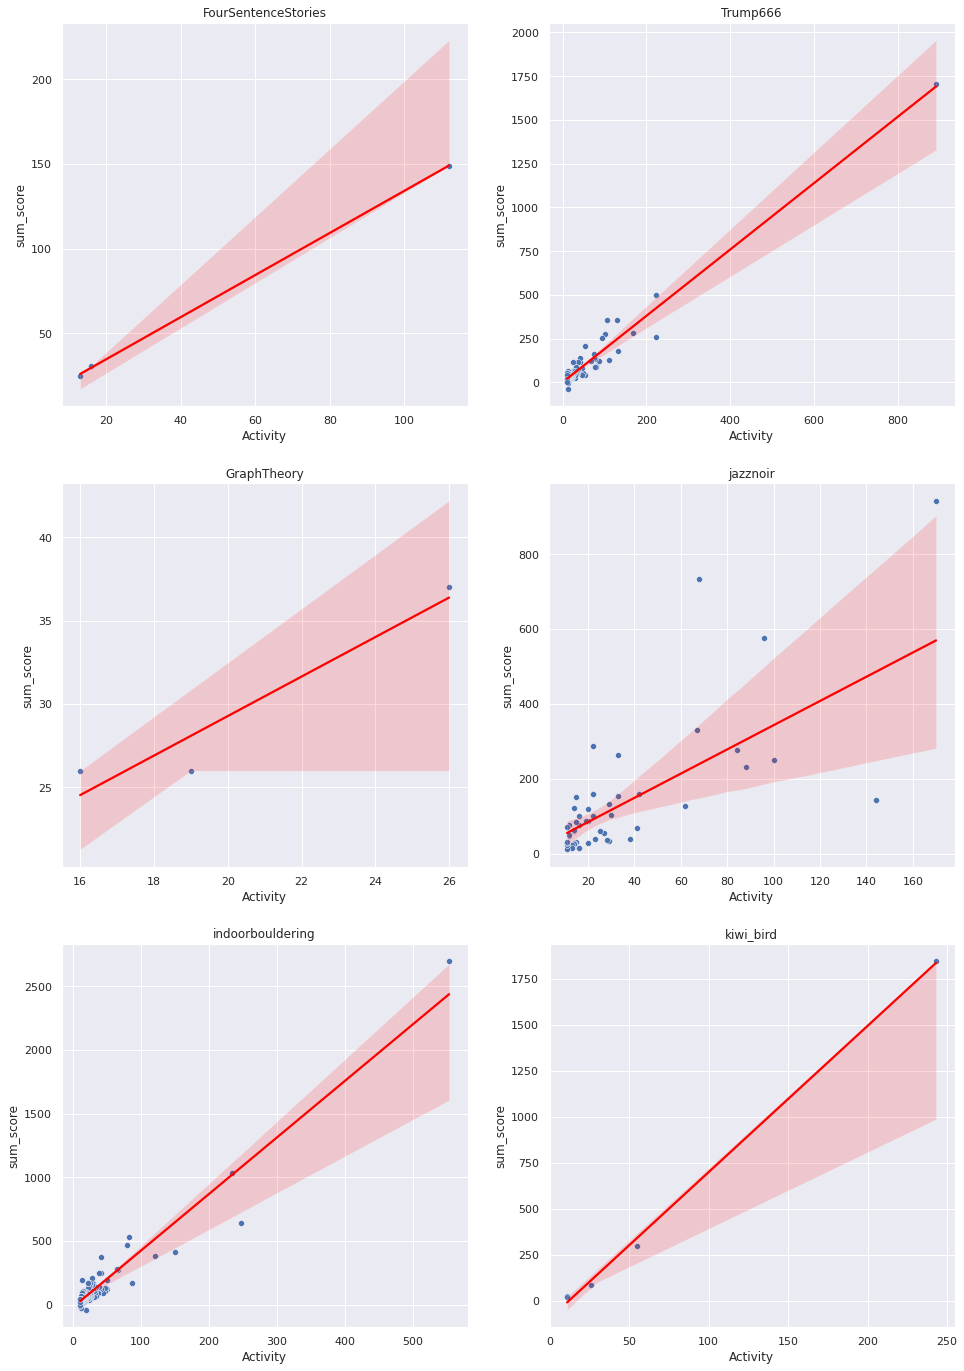

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(8*2,8*3))
axs = axs.flatten()
for i,subreddit in enumerate(subreddits):
    sns.scatterplot(x='Activity',y='sum_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i])
    # plot correlation line
    sns.regplot(x='Activity',y='sum_score',data=df_authors_dict[subreddit][df_authors_dict[subreddit]['Activity']>10],ax=axs[i],scatter=False,color='red')
    axs[i].set_title(subreddit)